# Extract & analyze San Francisco housing data
- using: Zillow via Beautiful Soup & Selenium
    - ex) Reddit uses Beautifu Soup to (try to) pull a representative image from posted links
- extracting: Address, Neighborhood, Price, Zestimate, Facts and Features, Posting Traffic, Posting Interest, and Posting Age
- purpose: capture listing data for analysis
- sources:
    - got started with: https://medium.com/@ben.sturm/scraping-house-listing-data-using-selenium-and-beautiful-soup-1cbb94ba9492

#### imports

In [48]:
import os
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import time
import sys
import numpy as np
import pandas as pd
import regex as re
import selenium
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import NoSuchElementException

#### function to alter Chrome window dimensions

In [99]:
def set_viewport_size(driver, width, height):
    window_size = driver.execute_script("""
        return [window.outerWidth - window.innerWidth + arguments[0],
          window.outerHeight - window.innerHeight + arguments[1]];
        """, width, height)
    driver.set_window_size(*window_size)

#### set up chromedriver

In [100]:
from fake_useragent import UserAgent

ua = UserAgent()
useragent = ua.random
options = webdriver.ChromeOptions()
print('--user-agent="'+str(useragent)+'"')

options.add_argument(f'user-agent={useragent}') #Path to random chrome profile
chrome_path = "c:\\bin\\chromedriver" # path to the chromedriver executable
driver = webdriver.Chrome(executable_path=chrome_path, chrome_options=options)
driver.wait=WebDriverWait(driver, 10)

set_viewport_size(driver, 800, 600) # set the viewport size to 800 x 600

--user-agent="Mozilla/5.0 (X11; CrOS i686 3912.101.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1453.116 Safari/537.36"


C:\Users\emag3\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: use options instead of chrome_options
  if sys.path[0] == '':


#### recaptcha handling

In [144]:
def _is_element_displayed(driver, elem_text, elem_type):
    if elem_type == "class":
        try:
            out = driver.find_element_by_class_name(elem_text).is_displayed()
        except (NoSuchElementException, TimeoutException):
            out = False
    elif elem_type == "css":
        try:
            out = driver.find_element_by_css_selector(elem_text).is_displayed()
        except (NoSuchElementException, TimeoutException):
            out = False
    else:
        raise ValueError("arg 'elem_type' must be either 'class' or 'css'")
    return(out)


# If captcha page is displayed, this function will run indefinitely until the 
# captcha page is no longer displayed (checks for it every 30 seconds).
# Purpose of the function is to "pause" execution of the scraper until the 
# user has manually completed the captcha requirements.
def _pause_for_captcha(driver):
    while True:
        time.sleep(30)
        if not _is_element_displayed(driver, "captcha-container", "class"):
            break

            
def check_for_captcha(driver):
    if _is_element_displayed(driver, "captcha-container", "class"):
        print("\nCAPTCHA!\n"\
              "Manually complete the captcha requirements.\n"\
              "Once that's done, if the program was in the middle of scraping "\
              "(and is still running), it should resume scraping after ~30 seconds.")
        _pause_for_captcha(driver)


def navigate_to_website(driver, site):
    driver.get(site)
    # Check to make sure a captcha page is not displayed.
    check_for_captcha(driver)

#### checking python path

In [101]:
sys.executable

'C:\\Users\\emag3\\Anaconda3\\python.exe'

#### open Chrome window with unfiltered SF Zillow link

In [102]:
zillow_sf_url = "https://www.zillow.com/homes/San-Francisco-CA_rb/"
driver.get(zillow_sf_url)

#### test: extracting links for each listing

In [ ]:
soup = BeautifulSoup(driver.page_source, 'html.parser')
listings = soup.find_all("a", class_="list-card-link")
listings[:5]

#### test: extracting the link to navigate to the next page of listings

In [ ]:
next_button = soup.find_all("li", class_="zsg-pagination-next")

print('https://www.zillow.com'+next_button[0].find('a').get('href',''))
 
print(a.find('a').get('href','') for a in next_button)

#### function returning every listing link (up to 20 pages worth)

In [55]:
def get_house_links(url, driver, pages=20):
    house_links=[]
    driver.get(url)
    for i in range(pages):
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        listings = soup.find_all("a", class_="list-card-link")
        # interested in the href attribute b/c it contains the actual clickable link
        page_data = [row['href'] for row in listings]
        house_links.append(page_data)
        time.sleep(2)
        next_button = soup.find_all("li", class_="zsg-pagination-next")
        time.sleep(2)
        if next_button[0].find('a') is not None:
            next_button_link = 'https://www.zillow.com'+next_button[0].find('a').get('href','')
        else:
            break

        if i<19:
            driver.get(next_button_link)
    
    return house_links

#### test: get_house_links

In [59]:
zillow_sf_url = "https://www.zillow.com/homes/San-Francisco-CA_rb/"
links = get_house_links(zillow_sf_url, driver)

#### capture every other URL from links in order to avoid duplicates

In [97]:
urls = []
for i in links:
    for j in i[::2]:
        urls.append(j)
        
print(urls)

['https://www.zillow.com/homedetails/1538-Visitacion-Ave-San-Francisco-CA-94134/15174451_zpid/', 'https://www.zillow.com/community/mira/2082609849_zpid/', 'https://www.zillow.com/community/san-francisco-shipyard-palisades/2083269123_zpid/', 'https://www.zillow.com/community/mira/2082609853_zpid/', 'https://www.zillow.com/homedetails/49-53-Guerrero-St-San-Francisco-CA-94103/2084992008_zpid/', 'https://www.zillow.com/community/san-francisco-shipyard-landing/2082903489_zpid/', 'https://www.zillow.com/community/san-francisco-shipyard-landing/2083281869_zpid/', 'https://www.zillow.com/homedetails/83-Mcallister-St-APT-204-San-Francisco-CA-94102/89240044_zpid/', 'https://www.zillow.com/community/mira/2082609854_zpid/', 'https://www.zillow.com/community/one-mission-bay/2084054918_zpid/', 'https://www.zillow.com/homedetails/355-1st-St-S-505-Aka-355-01st-St-San-Francisco-CA-94105/2081645302_zpid/', 'https://www.zillow.com/homedetails/201-Harrison-St-APT-823-San-Francisco-CA-94105/15148349_zpid/'

#### save links externally in text file

In [93]:
with open('SF Zillow house links.txt','w',encoding='utf-8') as file:
    file.write(str(urls))
    file.close()

['https://www.zillow.com/homedetails/1538-Visitacion-Ave-San-Francisco-CA-94134/15174451_zpid/', 'https://www.zillow.com/community/mira/2082609849_zpid/', 'https://www.zillow.com/community/san-francisco-shipyard-palisades/2083269123_zpid/', 'https://www.zillow.com/community/mira/2082609853_zpid/', 'https://www.zillow.com/homedetails/49-53-Guerrero-St-San-Francisco-CA-94103/2084992008_zpid/', 'https://www.zillow.com/community/san-francisco-shipyard-landing/2082903489_zpid/', 'https://www.zillow.com/community/san-francisco-shipyard-landing/2083281869_zpid/', 'https://www.zillow.com/homedetails/83-Mcallister-St-APT-204-San-Francisco-CA-94102/89240044_zpid/', 'https://www.zillow.com/community/mira/2082609854_zpid/', 'https://www.zillow.com/community/one-mission-bay/2084054918_zpid/', 'https://www.zillow.com/homedetails/355-1st-St-S-505-Aka-355-01st-St-San-Francisco-CA-94105/2081645302_zpid/', 'https://www.zillow.com/homedetails/201-Harrison-St-APT-823-San-Francisco-CA-94105/15148349_zpid/'

#### function returning html (bs4) for a given link

In [126]:
def get_html_data(url, driver):
    driver.get(url)
    time.sleep(np.random.lognormal(0,1))
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    return soup

#### function returning list of BeautifulSoup objects, one per URL

In [103]:
def get_soup(links, driver):
    all_soup = []
    for x in links:
        soup = get_html_data(x, driver)
        time.sleep(np.random.lognormal(0,1)+3)
        all_soup.append(soup)
    return all_soup
        
ult_soup = get_soup(urls, driver)

#625 URLs were scraped
#indices 0 through 91 are real links, remaining items are recaptcha
print(ult_soup[91])

#### save BeautifulSoup list externally in text file

In [28]:
with open('SF Zillow Soup - test.txt','w',encoding='utf-8') as file:
    for url in ult_soup:
        file.write(str(url)+"XXXXX")
    file.close()

#### import BeautifulSoup list from text file

In [ ]:
soup_test = []
with open("SF Zillow Soup - test.txt",encoding='utf-8') as f:
    text_list = list(f.read().split("XXXXX"))
    for url in text_list:
        s = BeautifulSoup(url, "html.parser")
        soup_test.append(s)
    soup_test = soup_test[:-1]

#### functions capturing listing details

In [67]:
def get_price(soup):
    prices=[]
    for s in soup:
        #using "find" instead of "find_all" to avoid duplicate prices
        price = s.find(True, {'class':'ds-value'})
        try:
            prices.append(''.join(price.text.split()))
        except:
            prices.append(None)
    return prices

get_price(soup_test)


def get_zestimate(soup):
    zestimates=[]
    for listing in soup:
        ballpark = listing.find("div", {'id':'ds-home-values'})
        try:
            text = ''.join(ballpark.text.split())
            zestimate_start = text.find('$')
            zestimate_end = 0
            for char in text[zestimate_start:]:
                if char.isalpha():
                    zestimate_end = text.index(char)
                    break
            zestimates.append(text[zestimate_start:zestimate_end])
        except:
            zestimates.append(None)
    return zestimates

get_zestimate(soup_test)


def get_beds(soup):
    beds=[]
    for listing in soup:
        living_info = listing.find_all(True, {'class':'ds-bed-bath-living-area-container'})
        try:
            bed_bath_sqft = living_info[0].find_all(True, {'class':'ds-bed-bath-living-area'},limit=3)
            num_beds = bed_bath_sqft[0].find_all('span', recursive=False)
            value = num_beds[0]
            num = ''.join(value.text.split())
            if ''.join(value.text.split()) == "--":
                num = None
            beds.append(num)
        except:
            beds.append(None)
    return beds

get_beds(soup_test)


def get_bath(soup):
    bath=[]
    for listing in soup:
        living_info = listing.find_all(True, {'class':'ds-bed-bath-living-area-container'})
        try:
            bed_bath_sqft = living_info[0].find_all(True, {'class':'ds-bed-bath-living-area'},limit=3)
            num_bath = bed_bath_sqft[1].find_all('span', recursive=False)
            value = num_bath[0]
            num = ''.join(value.text.split())
            if ''.join(value.text.split()) == "--":
                num = None
            bath.append(num)
        except:
            bath.append(None)
    return bath

get_bath(soup_test)


def get_sqft(soup):
    sqft=[]
    for listing in soup:
        living_info = listing.find_all(True, {'class':'ds-bed-bath-living-area-container'})
        try:
            bed_bath_sqft = living_info[0].find_all(True, {'class':'ds-bed-bath-living-area'},limit=3)
            num_sqft = bed_bath_sqft[2].find_all('span', recursive=False)
            value = num_sqft[0]
            num = ''.join(value.text.split())
            if ''.join(value.text.split()) == "--":
                num = None
            sqft.append(num)
        except:
            sqft.append(None)
    return sqft

get_sqft(soup_test)


def get_neighborhood(soup):
    neighborhood=[]
    for listing in soup:
        info = listing.find_all("div", {'class':'ds-expandable-card-section-default-padding'})
        try:
            nbhood_soup = info[2].find_all("span", {'class':'Text-sc-1vuq29o-0 iFtQDm'})
            possible_neighborhood = ''.join(nbhood_soup[1].text)
            if possible_neighborhood == 'San Francisco':
                possible_neighborhood = ''.join(nbhood_soup[0].text)
            neighborhood.append(possible_neighborhood)
        except:
            neighborhood.append(None)
    return neighborhood

get_neighborhood(soup_test)


#always in days
def get_age_of_listing(soup):
    age=[]
    for listing in soup:
        time_views_saves = listing.find_all("ul", {'class':'ds-overview-stats'})
        try:
            time_soup = time_views_saves[0].find_all("div", {'class':'ds-overview-stat-value'})
            time = ''.join(time_soup[0].text)
            time = time.split(' ', 1)[0]
            age.append(time)
        except:
            age.append(None)
    return age

get_age_of_listing(soup_test)


#views in last 30 days
def get_views(soup):
    views=[]
    for listing in soup:
        time_views_saves = listing.find_all("ul", {'class':'ds-overview-stats'})
        try:
            views_soup = time_views_saves[0].find_all("div", {'class':'ds-overview-stat-value'})
            view_count = ''.join(views_soup[1].text)
            #time = time.split(' ', 1)[0]
            views.append(view_count)
        except:
            views.append(None)
    return views

get_views(soup_test)


#saves in last 30 days
def get_saves(soup):
    saves=[]
    for listing in soup:
        time_views_saves = listing.find_all("ul", {'class':'ds-overview-stats'})
        try:
            saves_soup = time_views_saves[0].find_all("div", {'class':'ds-overview-stat-value'})
            save_count = ''.join(saves_soup[2].text)
            #time = time.split(' ', 1)[0]
            saves.append(save_count)
        except:
            saves.append(None)
    return saves

get_saves(soup_test)


def get_address(soup):
    addresses=[]
    for listing in soup:
        add = listing.find_all("h1", {'class':'ds-address-container'})
        try:
            address_html = add[0].find_all("span")
            address = ''.join(address_html[0].text)
            if 'Buildable plan: ' in address:
                address = address[16:]
            if 'Floor plan: ' in address:
                address = address[12:]
            addresses.append(address)
        except:
            addresses.append(None)
    return addresses

get_address(soup_test)


#import urls from text file
urls_import = []
with open("SF Zillow house links - load.txt",encoding='utf-8') as f:
    u = f.read()
    urls = u[1:-1].split(', ')
    for url in urls:
        urls_import.append(url[1:-1])
        
print(urls_import)

['$1,250,000',
 '$1,595,000',
 '$1,195,000',
 '$2,100,000',
 '$4,695,000',
 '$880,000',
 '$1,255,000',
 '$575,000',
 '$950,000',
 '$3,700,000',
 None,
 None,
 None,
 '$1,005,000',
 '$7,375,000',
 '$4,750,000',
 '$985,000',
 '$3,700,000',
 '$1,100,000',
 '$11,495,000',
 '$900,000',
 '$1,695,000',
 '$14,000,000',
 '$2,375,000',
 '$3,715,000',
 '$1,930,000',
 '$1,890,000',
 '$699,000',
 '$1,850,000',
 '$1,105,000',
 '$1,015,000',
 '$785,000',
 '$899,000',
 '$2,500,000',
 '$1,121,000',
 '$1,193,000',
 '$1,148,000',
 '$674,000',
 '$730,000',
 '$979,000',
 '$799,000',
 '$5,495,000',
 '$1,080,000',
 '$1,475,000',
 '$1,495,000',
 '$1,095,000',
 '$1,450,000',
 '$2,188,000',
 '$541,517',
 '$11,995,000',
 '$659,900',
 '$13,750,000',
 None,
 '$1,850,000',
 '$1,288,000',
 '$1,249,000',
 None,
 '$27,500,000',
 '$2,071,000',
 '$1,995,000',
 '$5,500,000',
 '$1,650,000',
 '$1,791,000',
 '$749,900',
 '$1,098,000',
 '$3,500,000',
 '$900,000',
 '$4,375,000',
 '$899,000',
 '$3,100,000',
 '$899,888',
 '$2,1

## Exploratory Data Analysis

#### create DataFrame from above functions

In [44]:
df = pd.DataFrame(list(zip(get_address(soup_test), get_neighborhood(soup_test), get_beds(soup_test), get_bath(soup_test), 
                           get_sqft(soup_test), get_age_of_listing(soup_test), get_views(soup_test), 
                           get_saves(soup_test), get_price(soup_test), get_zestimate(soup_test), urls_import)), 
               columns =['Address', 'Neighborhood', 'Beds', 'Bathrooms', 
                         'Sqft', 'ListingAge', 'Views',
                         'Saves', 'Price', 'Zestimate','URL'])

#### preview DataFrame

In [106]:
pd.set_option('display.width', 5000)
df.head(10)

,Address,Neighborhood,Beds,Bathrooms,Sqft,ListingAge,Views,Saves,Price,Zestimate,URL
0,"1538 Visitacion Ave,",Visitacion Valley,NaN,1.0,1260.0,1.0,297.0,6.0,1250000.0,918957.0,https://www.zillow.com/homedetails/1538-Visita...
1,"280 Spear Street #7B, MIRA,",Financial District,2.0,2.0,1293.0,1.0,164.0,6.0,1595000.0,1577361.0,https://www.zillow.com/community/mira/20826098...
2,"Plan A1, The San Francisco Shipyard : Palisades,",Hunters Point,3.0,3.0,1522.0,2.0,197.0,1.0,1195000.0,1229011.0,https://www.zillow.com/community/san-francisco...
3,"280 Spear Street #14E, MIRA,",Financial District,2.0,2.0,1347.0,2.0,129.0,2.0,2100000.0,2057894.0,https://www.zillow.com/community/mira/20826098...
4,"49 53 Guerrero St,",Mint Hill,NaN,NaN,6741.0,3.0,416.0,1.0,4695000.0,4695728.0,https://www.zillow.com/homedetails/49-53-Guerr...
5,"10 Innes Ct #304, The San Francisco Shipyard :...",Hunters Point,2.0,2.0,1020.0,3.0,251.0,1.0,880000.0,899911.0,https://www.zillow.com/community/san-francisco...
6,"10 Innes Ct #401, The San Francisco Shipyard :...",Hunters Point,3.0,2.0,1256.0,3.0,50.0,3.0,1255000.0,1285017.0,https://www.zillow.com/community/san-francisco...
7,"83 Mcallister St APT 204,",Civic Center,1.0,1.0,412.0,4.0,1434.0,17.0,575000.0,501667.0,https://www.zillow.com/homedetails/83-Mcallist...
8,"280 Spear Street #3Q, MIRA,",Financial District,1.0,1.0,638.0,4.0,552.0,9.0,950000.0,958951.0,https://www.zillow.com/community/mira/20826098...
9,"#1401, ONE Mission Bay,",Mission Bay,3.0,3.0,1976.0,4.0,48.0,1.0,3700000.0,3569573.0,https://www.zillow.com/community/one-mission-b...


#### number of usable rows (after recaptcha)

In [87]:
int(df.size/len(df.columns))

92

#### frequency of common feature values

In [120]:
for col in df[['Neighborhood', 'Beds', 'Bathrooms']]:
    print(df[col].value_counts())
    print('Number of unique values: {0}\n'.format(df[col].nunique()))

Hunters Point            9
Financial District       8
Rincon Hill              7
Mission Bay              6
Dogpatch                 5
South of Market          3
Parkside                 3
Outer Richmond           3
Russian Hill             3
Eureka Valley            3
Cow Hollow               2
Noe Valley               2
Sutro Heights            2
Golden Gate Heights      2
Outer Sunset             2
Silver Terrace           2
Buena Vista              2
Mission                  2
Marina                   1
Presidio Heights         1
Inner Richmond           1
Cathedral Hill           1
Bayview                  1
Laguna Honda             1
Candlestick Point SRA    1
Telegraph Hill           1
Mint Hill                1
Lower Pacific Heights    1
Civic Center             1
Forest Knolls            1
Visitacion Valley        1
Stonestown               1
Excelsior                1
Diamond Heights          1
Nob Hill                 1
Cole Valley              1
Clarendon Heights        1
B

#### check column types

In [89]:
for col in df[['Beds', 'Bathrooms', 'Sqft', 'ListingAge',
               'Views', 'Saves', 'Price', 'Zestimate']]:
    print(df[col].apply(type))
    print(df[col].iat[0])

0     <class 'float'>
1     <class 'float'>
2     <class 'float'>
3     <class 'float'>
4     <class 'float'>
           ...       
87    <class 'float'>
88    <class 'float'>
89    <class 'float'>
90    <class 'float'>
91    <class 'float'>
Name: Beds, Length: 92, dtype: object
nan
0     <class 'float'>
1     <class 'float'>
2     <class 'float'>
3     <class 'float'>
4     <class 'float'>
           ...       
87    <class 'float'>
88    <class 'float'>
89    <class 'float'>
90    <class 'float'>
91    <class 'float'>
Name: Bathrooms, Length: 92, dtype: object
1.0
0     <class 'str'>
1     <class 'str'>
2     <class 'str'>
3     <class 'str'>
4     <class 'str'>
          ...      
87    <class 'str'>
88    <class 'str'>
89    <class 'str'>
90    <class 'str'>
91    <class 'str'>
Name: Sqft, Length: 92, dtype: object
1,260
0     <class 'str'>
1     <class 'str'>
2     <class 'str'>
3     <class 'str'>
4     <class 'str'>
          ...      
87    <class 'str'>
88    <class 'str'>
89 

#### clean numeric features and convert from string to float

In [90]:
mask = df.applymap(lambda x: x is None)
cols = df.columns[(mask).any()]
for col in df[cols]:
    df.loc[mask[col], col] = ''

for col in df[['Beds', 'Bathrooms', 'Sqft', 'ListingAge', 'Views', 'Saves', 'Price', 'Zestimate']]:
    df[col] = df[col].str.replace(',','')
    df[col] = df[col].str.replace('$','')
    df[col] = pd.to_numeric(df[col])
    print(df[col].apply(type))

0     <class 'float'>
1     <class 'float'>
2     <class 'float'>
3     <class 'float'>
4     <class 'float'>
           ...       
87    <class 'float'>
88    <class 'float'>
89    <class 'float'>
90    <class 'float'>
91    <class 'float'>
Name: Sqft, Length: 92, dtype: object
0     <class 'float'>
1     <class 'float'>
2     <class 'float'>
3     <class 'float'>
4     <class 'float'>
           ...       
87    <class 'float'>
88    <class 'float'>
89    <class 'float'>
90    <class 'float'>
91    <class 'float'>
Name: ListingAge, Length: 92, dtype: object
0     <class 'float'>
1     <class 'float'>
2     <class 'float'>
3     <class 'float'>
4     <class 'float'>
           ...       
87    <class 'float'>
88    <class 'float'>
89    <class 'float'>
90    <class 'float'>
91    <class 'float'>
Name: Views, Length: 92, dtype: object
0     <class 'float'>
1     <class 'float'>
2     <class 'float'>
3     <class 'float'>
4     <class 'float'>
           ...       
87    <class 'float'>

#### numeric columns are now prepped for analysis

In [109]:
df.describe()

,Beds,Bathrooms,Sqft,ListingAge,Views,Saves,Price,Zestimate
count,82.000000,89.000000,89.000000,91.000000,91.000000,91.000000,8.700000e+01,8.800000e+01
mean,2.780488,2.325843,1962.179775,53.241758,2146.329670,42.934066,2.906336e+06,2.387608e+06
std,1.379071,1.544972,2002.515609,66.912105,1778.464144,43.471268,4.151220e+06,2.880340e+06
min,1.000000,1.000000,409.000000,1.000000,19.000000,0.000000,1.968420e+05,1.200000e+00
25%,2.000000,1.000000,1000.000000,7.000000,405.500000,6.000000,9.590000e+05,9.311775e+05
50%,3.000000,2.000000,1368.000000,15.000000,2057.000000,32.000000,1.399000e+06,1.377894e+06
75%,3.000000,3.000000,2198.000000,88.500000,3329.500000,69.000000,2.437500e+06,2.203159e+06
max,7.000000,11.000000,16000.000000,307.000000,7311.000000,197.000000,2.750000e+07,1.307252e+07


#### summary statistics for Price by SF Neighborhood

In [137]:
pd.set_option('display.float_format', lambda x: '%.1f' % x)

group = df.groupby('Neighborhood').agg({'Price': ['min', 'max', 'mean']})
group = group.sort_values(by=[('Price', 'mean')], ascending=False)
print(group)

                           Price                      
                             min        max       mean
Neighborhood                                          
Cow Hollow             1200000.0 27500000.0 14350000.0
Presidio Heights      13750000.0 13750000.0 13750000.0
Nob Hill              12900000.0 12900000.0 12900000.0
South of Market        3715000.0 14000000.0  9538333.3
Rincon Hill             699000.0 11495000.0  6352600.0
Marina                 5500000.0  5500000.0  5500000.0
Russian Hill           1690000.0 11995000.0  5395000.0
Mint Hill              4695000.0  4695000.0  4695000.0
Clarendon Heights      4375000.0  4375000.0  4375000.0
Eureka Valley          1688900.0  5495000.0  3561300.0
Potrero Hill           3395000.0  3395000.0  3395000.0
Bernal Heights         3100000.0  3100000.0  3100000.0
St. Francis Wood       2878000.0  2878000.0  2878000.0
Mission Bay             769000.0  3700000.0  2263666.7
Cole Valley            1995000.0  1995000.0  1995000.0
Laguna Hon

#### distributions for numeric features

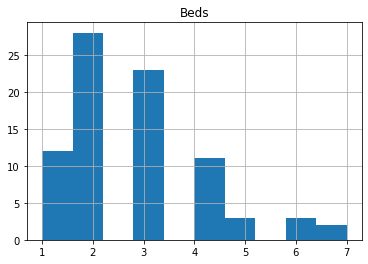

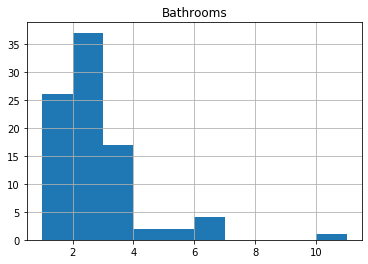

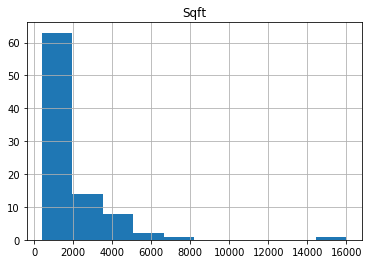

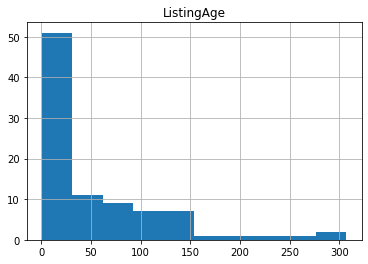

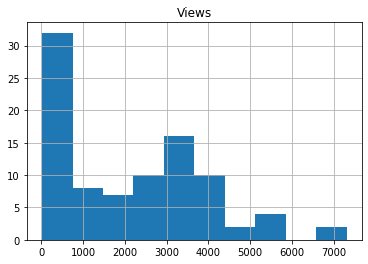

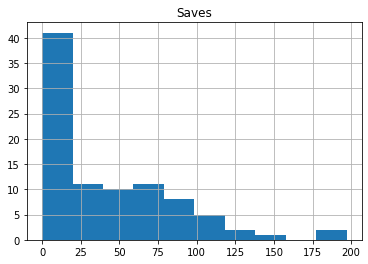

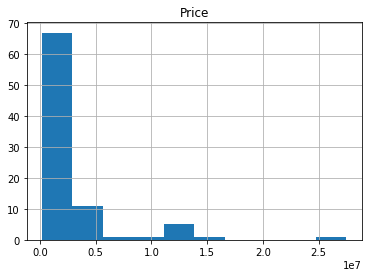

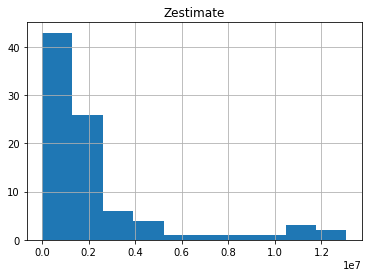

In [142]:
import matplotlib.pyplot as plt

for col in df[['Beds', 'Bathrooms', 'Sqft', 'ListingAge', 'Views', 'Saves', 'Price', 'Zestimate']]:
    df.hist(column=col)